## P5 - ¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?

**Aclaraciones**  
- Prestaciones = Consultas medicas  

Al momento decir "posibles" se da a entender que por "cultura general" se puede saber el motivo de cierto patron en el analisis de datos, que de todas formas se puede comprobar con los datasets, pero no es pertinente su analisis en el momento, a fin de seguir el hilo de analisis de la pregunta.

### Introduccion

El tiempo no pasa factura, es sabido que a medida que uno envejece suele ir con mayor frecuencia al medico y por implicancia sus gastos medicos deben aumentar, pero la pregunta es... Que tanto aumentan estos gastos, existe un punto de quiebre o es gradual?.  
~~Más aun, se puede predecir el gasto promedio medico en Chile segun la edad de personas adscritas a FONASA?. Si pensamos en agrupar segun region, genero, tramo de fonasa, etc... existen diferencias clave?~~

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns

# Abrimos una muestra de los datasets
with open("Beneficiarios Innominada 2023/export MLE 2023.csv", encoding="utf-8", errors="ignore") as f:
    benef_2023_df = pd.read_csv(f, nrows=1000000)
with open("Beneficiarios Innominada 2023/Beneficiarios Fonasa 2023.csv", encoding="utf-8", errors="ignore") as f:
    mle_2023_df = pd.read_csv(f, nrows=1000000)
codigos_df = pd.read_excel("data/2 Planilla MLE 2023.xlsx", engine="openpyxl")

In [ ]:
mle_2023_df = mle_2023_df.rename(columns={"PRESTRACIONES": "PRESTACIONES"})


In [4]:
%%capture
benef_2023_df

In [5]:
%%capture
mle_2023_df

In [6]:
%%capture
codigos_df

**Elección de variables**  
Como buscamos medir los gastos medicos promedio a medida que una persona envejece, pero tomando en cuenta que no tenemos el historial medico completo de una persona (Lo ideal) usaremos:
1. La "EDAD_TRAMO", puesto que analizaremos un promedio en gastos, para todo el tramo edad del año 2023.
2. El "MONTO_COPAGO" para conocer el monto a pagar por cada prestacion.  
3. Opcional: El "SEXO" para especificar el analisis, pero podria ser cualquiera; "TRAMO_FONASA", "REGION_EMISION", "MES_EMISION", etc...

In [7]:
# Ordenar los datos por "EDAD_TRAMO"
benef_2023_df["EDAD_TRAMO_ORDEN"] = (benef_2023_df["EDAD_TRAMO"].str.extract(r"(\d+)").astype("Int64"))
benef_2023_df = benef_2023_df.sort_values("EDAD_TRAMO_ORDEN")

In [ ]:
# Diccionario con los valores a reemplazar
mapeo_tramos = {
    "00 a 02 aos": "00 a 02 años",
    "03 a 04 aos": "03 a 04 años",
    "05 a 09 aos": "05 a 09 años",
    "10 a 14 aos": "10 a 14 años",
    "15 a 19 aos": "15 a 19 años",
    "20 a 24 aos": "20 a 24 años",
    "25 a 29 aos": "25 a 29 años",
    "30 a 34 aos": "30 a 34 años",
    "35 a 39 aos": "35 a 39 años",
    "40 a 44 aos": "40 a 44 años",
    "45 a 49 aos": "45 a 49 años",
    "50 a 54 aos": "50 a 54 años",
    "55 a 59 aos": "55 a 59 años",
    "60 a 64 aos": "60 a 64 años",
    "65 a 69 aos": "65 a 69 años",
    "70 a 74 aos": "70 a 74 años",
    "75 a 79 aos": "75 a 79 años",
    "80 a 84 aos": "80 a 84 años",
    "85 a 89 aos": "85 a 89 años",
    "90 a 94 aos": "90 a 94 años",
    "95 a 99 aos": "95 a 99 años",
    "Ms de 99 aos": "Más de 99 años"
}

# Reemplazar los valores en la columna
benef_2023_df["EDAD_TRAMO"] = benef_2023_df["EDAD_TRAMO"].replace(mapeo_tramos)

print(benef_2023_df["EDAD_TRAMO"].unique())

['00 a 02 años' '03 a 04 años' '05 a 09 años' '10 a 14 años'
 '15 a 19 años' '20 a 24 años' '25 a 29 años' '30 a 34 años'
 '35 a 39 años' '40 a 44 años' '45 a 49 años' '50 a 54 años'
 '55 a 59 años' '60 a 64 años' '65 a 69 años' '70 a 74 años'
 '75 a 79 años' '80 a 84 años' '85 a 89 años' '90 a 94 años'
 '95 a 99 años' 'Más de 99 años' nan]


**Distribución de los datos**  
En primera instancia, veremos la distribución de los datos por tramo de edad.

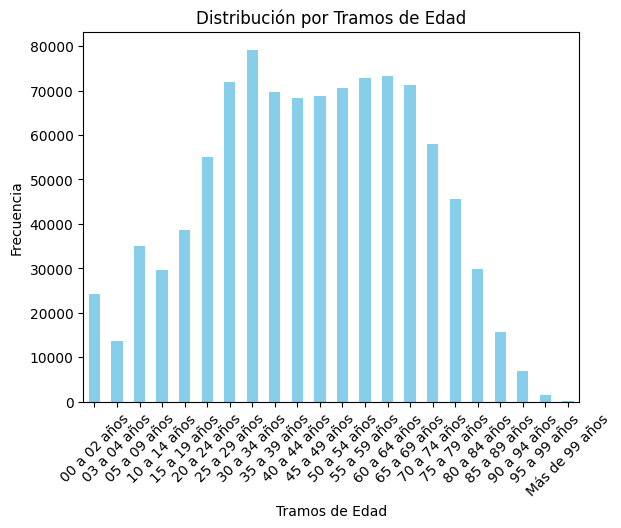

In [ ]:
benef_2023_df["EDAD_TRAMO"].value_counts(sort=False).plot(kind="bar", color="skyblue")
plt.title("Distribucion por Tramos de Edad")
plt.xlabel("Tramos de Edad")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

Observando la distribucion vemos que estos forman una campana de Gauss. Esto significa que los valores centrales concentran la mayor cantidad de datos, mientras que los valores extremos tienen menos ocurrencias, por lo tanto y aportado a la pregunta Aportando *¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?*, en si, las personas suelen ir con mayor frecuencia a realizar consultas medicas u otras prestaciones. Ahora toca saber el valor de estas.  

He de añadir.  
Esto ocasiona un sesgo de la distribución, puede tener implicaciones para la posible creacion de un modelo predictivo. Al haber menos datos en las colas de la distribución, el modelo pueden tener dificultades para aprender patrones robustos en estas regiones, a tomar en cuenta.  
En concreto:  
- Infantes de "0 a 2 años" tiene mayor ocurrencia que su edad posterior "3 a 4 años", evidenciandose en mayor prevencion en recien nacidos y uso de consultas mas especificas a dicha edad.
- Entre los "25 a 29 años" y "65 a 69" años la ocurrencia es muy similar.
- A partir de los "70 a 79 años" la ocurrencia empieza a bajar, probablemente por la menor tasa de personas que viven mas alla de 70 años.  

**Analizaremos el promedio por tramo de edad:**

In [ ]:
benef_edad_23 = benef_2023_df.groupby(["EDAD_TRAMO", "SEXO"])["MONTO_COPAGO"].mean()
print(benef_edad_23)


EDAD_TRAMO      SEXO  
00 a 02 años    Hombre    11272.767431
                Mujer     10957.318547
03 a 04 años    Hombre    12486.628171
                Mujer     11221.627699
05 a 09 años    Hombre    12912.898454
                Mujer     11171.912787
10 a 14 años    Hombre    12641.972155
                Mujer     12029.702041
15 a 19 años    Hombre    15953.791733
                Mujer     13408.101637
20 a 24 años    Hombre    17383.075188
                Mujer     16062.166002
25 a 29 años    Hombre    19994.656005
                Mujer     18075.685368
30 a 34 años    Hombre    20756.918121
                Mujer     18369.404659
35 a 39 años    Hombre    19498.932818
                Mujer     18769.340515
40 a 44 años    Hombre    19549.086123
                Mujer     18471.363302
45 a 49 años    Hombre    19910.579623
                Mujer     18181.051916
50 a 54 años    Hombre    18516.135377
                Mujer     18327.051615
55 a 59 años    Hombre    19480.669483
  

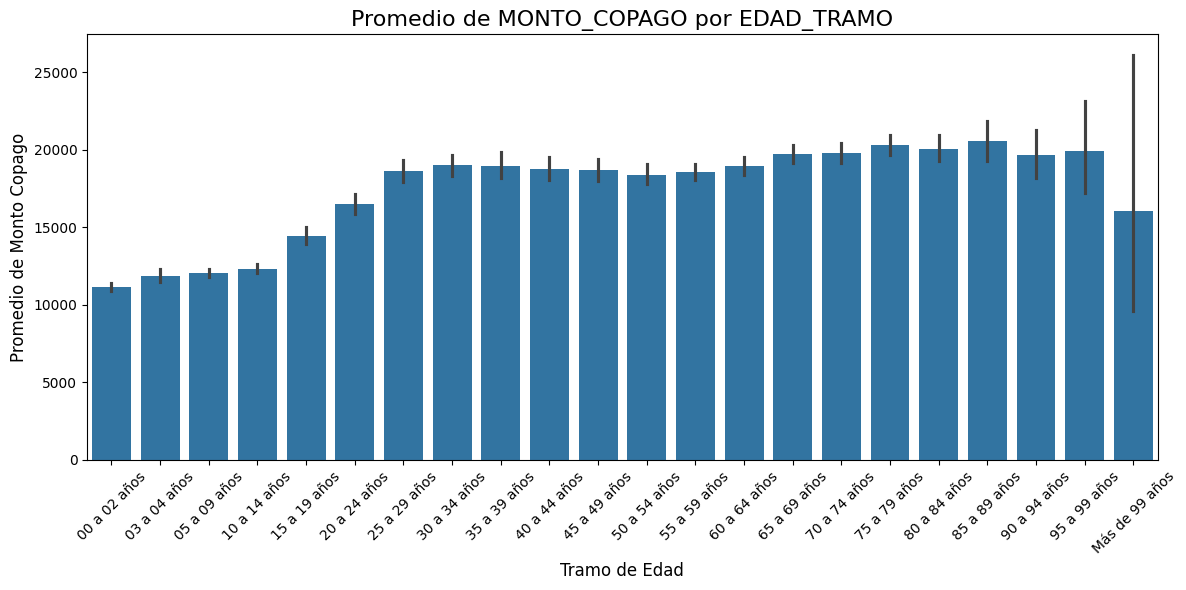

In [12]:
# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(
    data=benef_2023_df, 
    x="EDAD_TRAMO", 
    y="MONTO_COPAGO", 
    estimator="mean",
)

plt.title("Promedio de MONTO_COPAGO por EDAD_TRAMO", fontsize=16)
plt.xlabel("Tramo de Edad", fontsize=12)
plt.ylabel("Promedio de Monto Copago", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Analisis grafico**  
Como era de esperar, el promedio del monto de copago aumenta a medida que se incrementa la edad. En concreto, a partir de los 15-19 años se observa un aumento en el gasto medio, probablemente debido al incremento en el número de consultas realizadas por la misma persona y al mayor costo de prestaciones que no son del tipo "pediátricas".

El aumento del gasto es lineal hasta el tramo de los "90 a 94 años", desde donde comienza a disminuir, probablemente debido a una reducción en el uso de ciertos servicios médicos por parte de personas de edad avanzada.

**¿Son estos valores anteriores "correctos"?**  
Es necesario tener en cuenta:  
Por análisis previos, sabemos que en cada tramo de edad existen prestaciones significativamente más costosas, como operaciones, tratamientos o días de hospitalización, y otras más económicas, como consultas médicas o análisis de laboratorio.

Por un lado, combinar prestaciones más económicas y de mayor frecuencia con aquellas más costosas y de menor frecuencia es representativo de la realidad, ya que, aunque no todos enfrentan gastos médicos elevados, nadie está completamente exento de experimentar algún accidente, enfermedad hereditaria o consecuencias de malos hábitos. Por ende, esta "mezcla" de ambos tipos de prestaciones médicas refleja adecuadamente el espectro de costos en la vida de una persona.

Dicho lo anterior y solo con el grafico anterior
Aún no es posible si los valores son "correctos"; no solo nos interesa conocer el promedio, sino también cómo se distribuyen los valores alrededor de él, *es necesario realizar un BoxPlot*, ya que los cuartiles ayudan a detectar si existen personas con gastos excesivamente altos o bajos en comparación con la mayoría, lo que podría distorsionar los resultados.  

**Creacion de BoxPlot**  
En primer intento se busco crear el box plot con todos los valores de "MONTO_COPAGO" pero existian valores muy atipicos sobre 1 millon que dificultan la visualizacion del boxplot, por ende se calculara el IQR para analisar 2 graficos:  
1. "MONTO_COPAGO" Bajo el IQR original  
2. "MONTO_COPAGO" Sobre el IQR original

### Cuartil <Q3

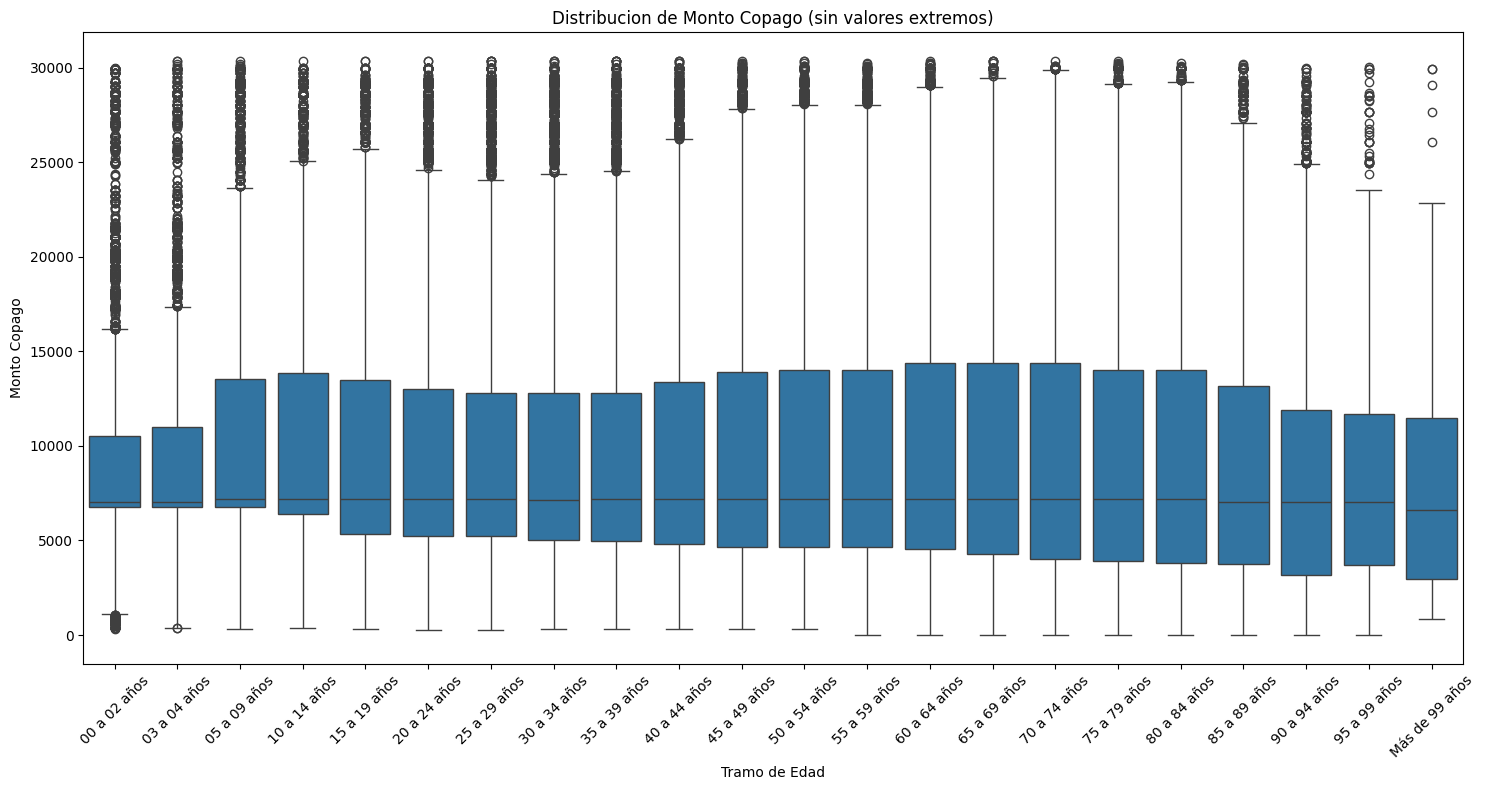

In [13]:
# Calculamos Q1, Q3 y el rango intercuartilico (IQR)
Q1 = benef_2023_df["MONTO_COPAGO"].quantile(0.25)
Q3 = benef_2023_df["MONTO_COPAGO"].quantile(0.75)
IQR = Q3 - Q1

# Asignamos limitees
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Filtrramos segun limites
benef_q3_df = benef_2023_df[(benef_2023_df["MONTO_COPAGO"] >= limite_inf) & 
                            (benef_2023_df["MONTO_COPAGO"] <= limite_sup)]
benef_q4_df = benef_2023_df[(benef_2023_df["MONTO_COPAGO"] > limite_sup)]

# Graficar
plt.figure(figsize=(15, 8))
sns.boxplot(data=benef_q3_df, x="EDAD_TRAMO", y="MONTO_COPAGO")
plt.xticks(rotation=45)
plt.title("Distribucion de Monto Copago (sin valores extremos)")
plt.xlabel("Tramo de Edad")
plt.ylabel("Monto Copago")
plt.tight_layout()
plt.show()


En el cuartil bajo el 75% tenemos el analisis de los siguientes subcuartiles (Todo con el fin de una mayor visualualizacion)  
- En Edad tramo 0 a 2 años, los copagos estan muy concentrado, su 2do y 3er cuartil es muy estrecho, alrededor 7000 pesos por copago.  
- A medida que la edad aumenta, el 3er cuartil tienden a estar menor concentrado, reflejando una mayor variedad de montos de copago y por ende, de tipos de prestaciones. Aun asi la media siempre suele estar en los 7000, he de existir una consulta medica demasiado frecuente que este ese valor, lo mas probable sea una "Consulta medica general".  
- Ahora sumando a nuestra pregunta *¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?*, se infiere que a medida que la persona tiene mayor edad, el tipo de prestacion y su copago tienden a valores mas altos, evindenciando en el 3er cuartil de los datos.


In [14]:
# Buscar "MONTO_COPAGO" mas alto
benef_q3_df.loc[benef_q3_df["MONTO_COPAGO"].idxmax()]

MES_EMISION                               202302
CODIGO_PRESTACIN                          902020
DESC_SECCION                 Otros Profesionales
DESC_ITEM                       Psicologa Clnica
CODIGO_BENEFICIARIO                     97324621
TRAMO_FONASA                                   D
EDAD_TRAMO                          03 a 04 años
SEXO                                      Hombre
REGION_EMISION         Metropolitana De Santiago
COMUNA_EMISION                        La Florida
PRESTRACIONES                                1.0
MONTO_FAM                                  13790
MONTO_COPAGO                               30350
EDAD_TRAMO_ORDEN                               3
Name: 494921, dtype: object

### Cuartil >Q3

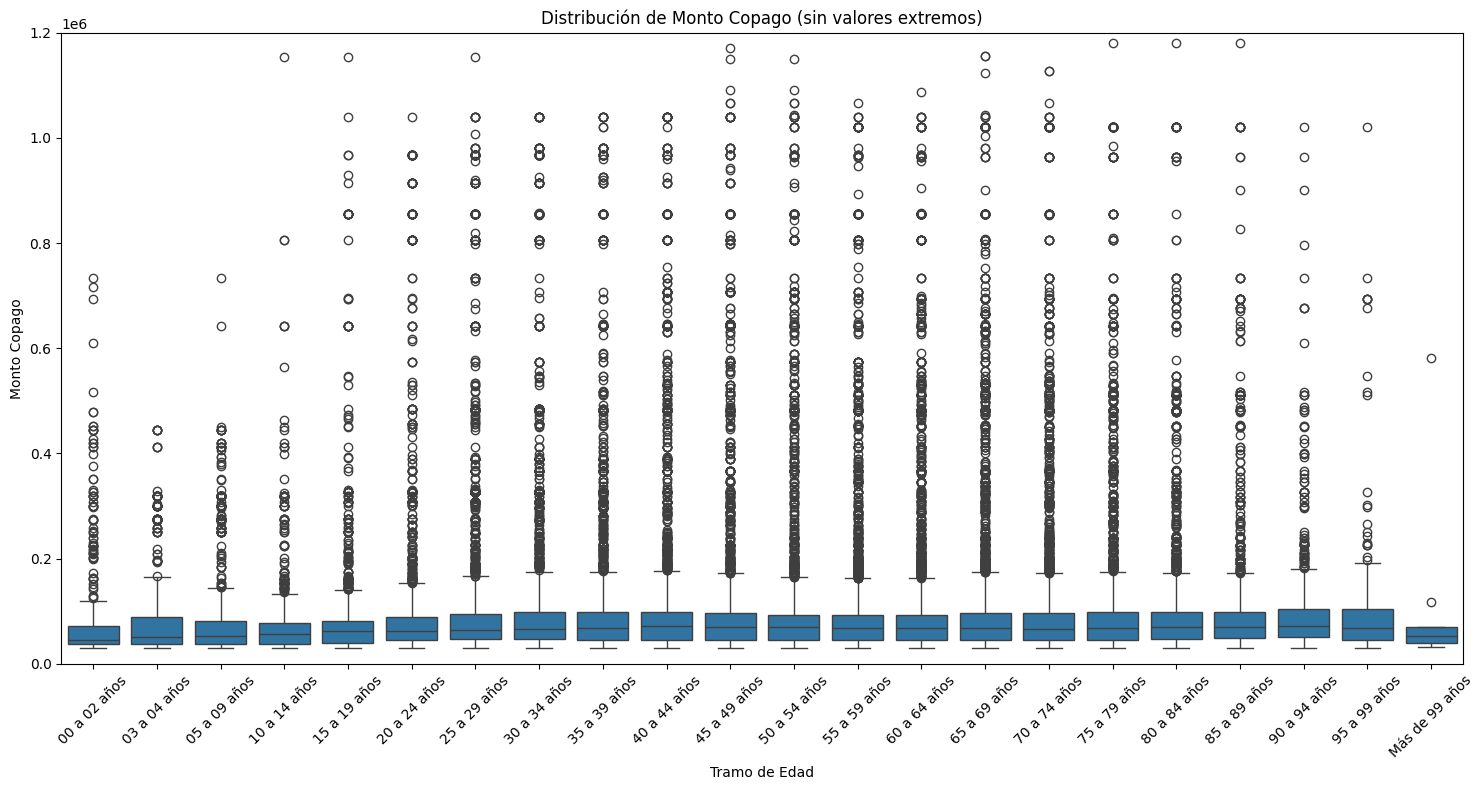

In [15]:
# Graficar
plt.figure(figsize=(15, 8))
sns.boxplot(data=benef_q4_df, x="EDAD_TRAMO", y="MONTO_COPAGO")
plt.ylim(0, 1200000)
plt.xticks(rotation=45)
plt.title("Distribución de Monto Copago (sin valores extremos)")
plt.xlabel("Tramo de Edad")
plt.ylabel("Monto Copago")
plt.tight_layout()
plt.show()

Respecto al cuartil superior al 75% de los datos, prestaciones con copago superior a 25000 pesos, los box plot suelen ser muy similares entre los "15 a 19 años" hasta los "85 a 89 años", la media esta en 60000 pesos, por otro lado los extremos aun tiene copagos mas reducidos.  
Ahora bien para responder nuestra pregunta, resulta muy interesante conocer que entre los tramos de "20 a 24 años" hasta los "75 a 79 años" las prestaciones de muy alto costo sobre los 100000 pesos, considerados valores atipicos, tienen muchos datos que si bien no se refleja en los cuartiles, si se puede ver que los datos atipicos aumentan, y por ende el inesperado gasto medico

**Ahora, crearemos un histograma para cada tramo de edad, donde:**  
- Eje x: "MONTO_COPAGO"  
- Eje y: Frecuencia de prestaciones

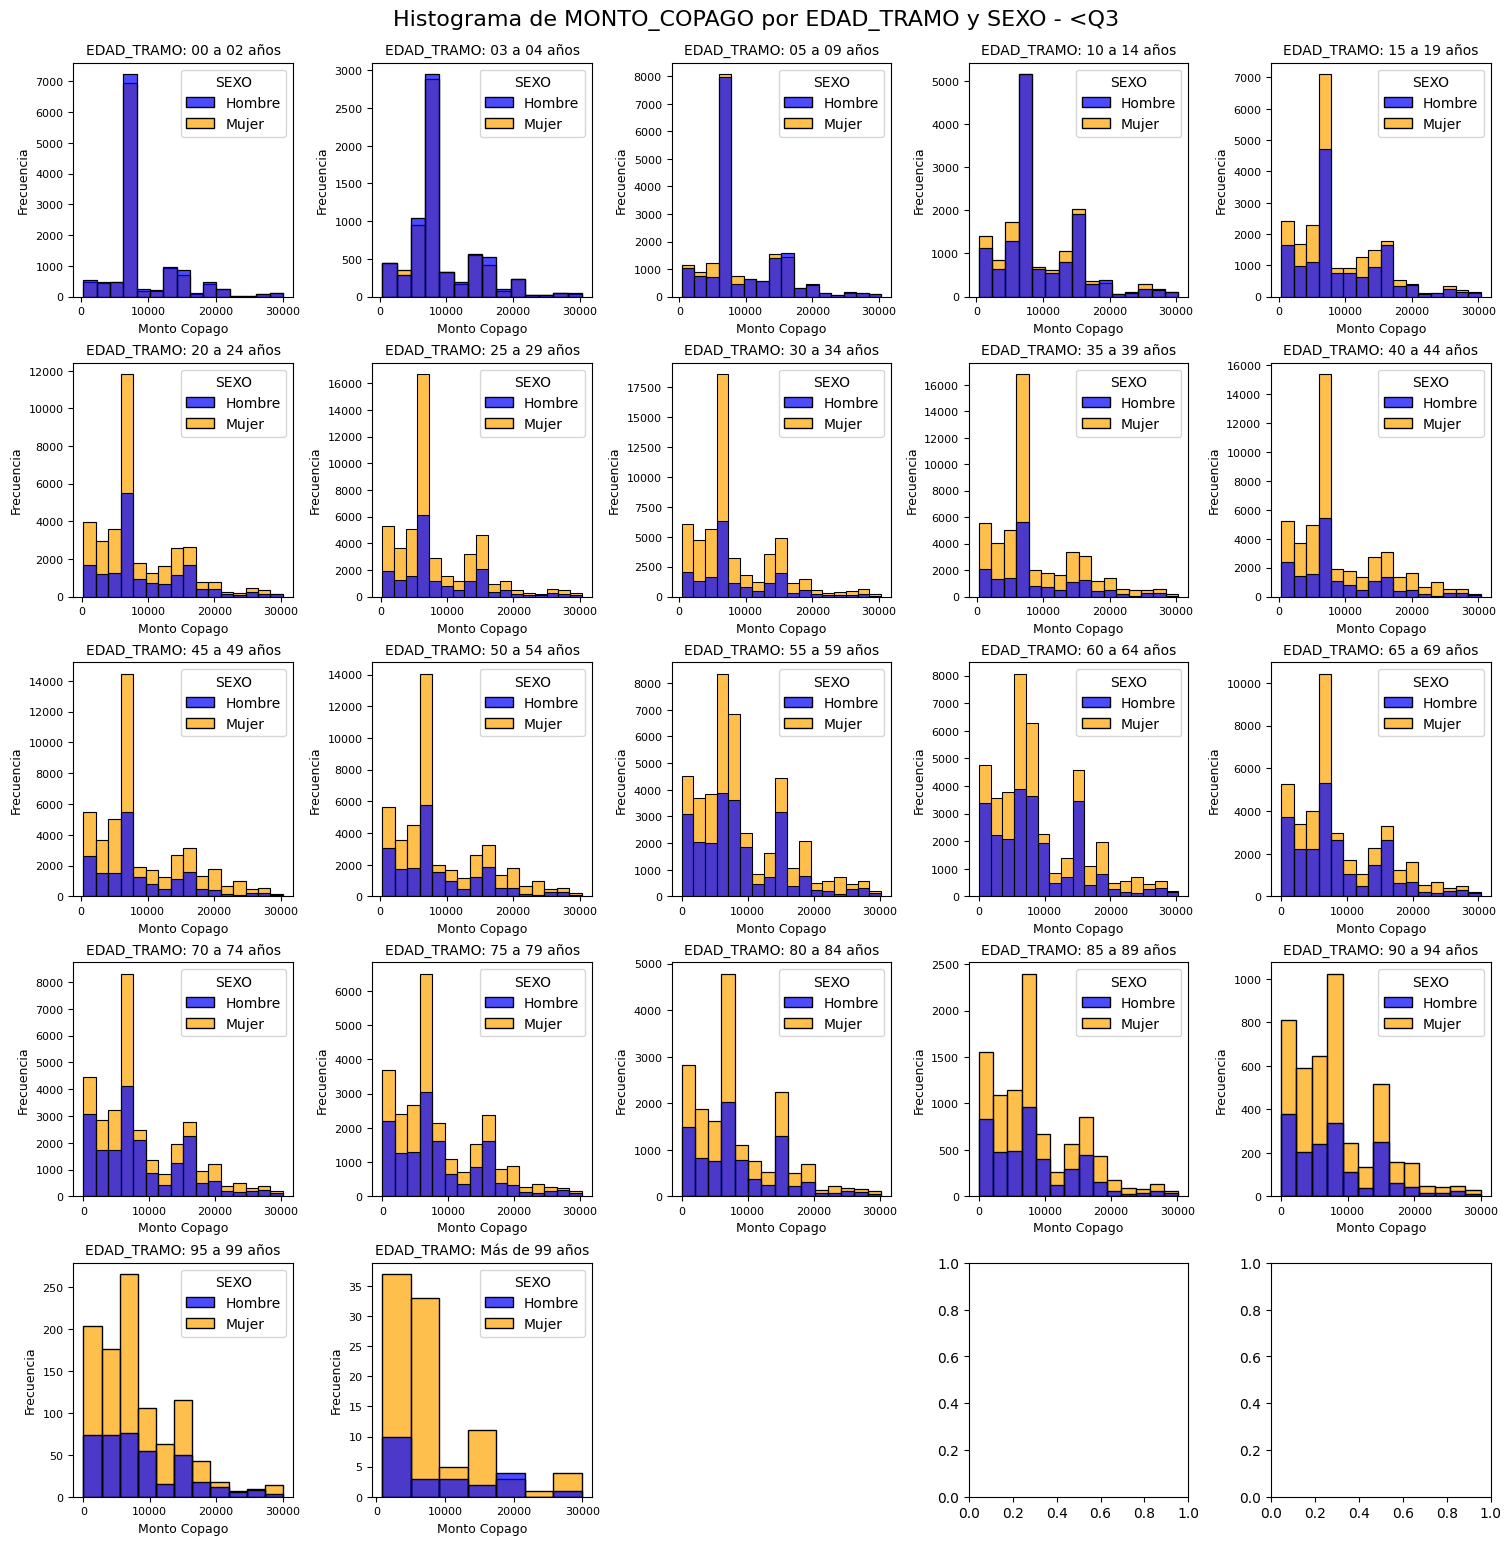

In [ ]:
edad_tramos = benef_q3_df["EDAD_TRAMO"].unique()

# Config de la cuadricula de subplots
num_tramos = len(edad_tramos)
cols = 5
rows = int(np.ceil(num_tramos / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), constrained_layout=True)
axes = axes.flatten()

# Iterar por cada tramo de edad
for i, tramo in enumerate(edad_tramos):
    datos_tramo = benef_q3_df[benef_q3_df["EDAD_TRAMO"] == tramo]
    
    if len(datos_tramo) > 0:
        # bins segun regla de sturges en log2
        nbins = max(1, int(np.log2(len(datos_tramo)) + 1))
        color_palette = {"Hombre": "blue", "Mujer": "orange"}
        hue_order = ["Hombre", "Mujer"]

        # histograma con hue = "SEXO"
        sns.histplot(
            data=datos_tramo,
            x="MONTO_COPAGO",
            hue="SEXO",
            bins=nbins,
            ax=axes[i],
            kde=False,
            hue_order=hue_order,
            palette=color_palette,
            edgecolor="black",
            alpha=0.7
        )
        
        # Personalizar
        axes[i].set_title(f"EDAD_TRAMO: {tramo}", fontsize=10)
        axes[i].set_xlabel("Monto Copago", fontsize=9)
        axes[i].set_ylabel("Frecuencia", fontsize=9)
        axes[i].tick_params(axis="x", labelsize=8)
        axes[i].tick_params(axis="y", labelsize=8)
    else:
        axes[i].axis("off")

fig.suptitle("Histograma de MONTO_COPAGO por EDAD_TRAMO y SEXO - <Q3", fontsize=16, y=1.02)
plt.show()

Al entrar en detalle del histograma segun "TRAMO_EDAD" podemos confirmar las conclusiones del boxplot:  
- La media suele estar en 7000
- A medida que aumenta la edad, la frecuecia de prestaciones de mayor valor aumenta
- Las prestaciones alrededor de 15000, aumentan constantemente a medida que el tramo de edad aumenta, hasta llegar a los 85 a 80 años

- Con la nueva variable "SEXO" agregada al HUE, podemos decir que las prestaciones totales para mujeres es casi el doble que de hombres.

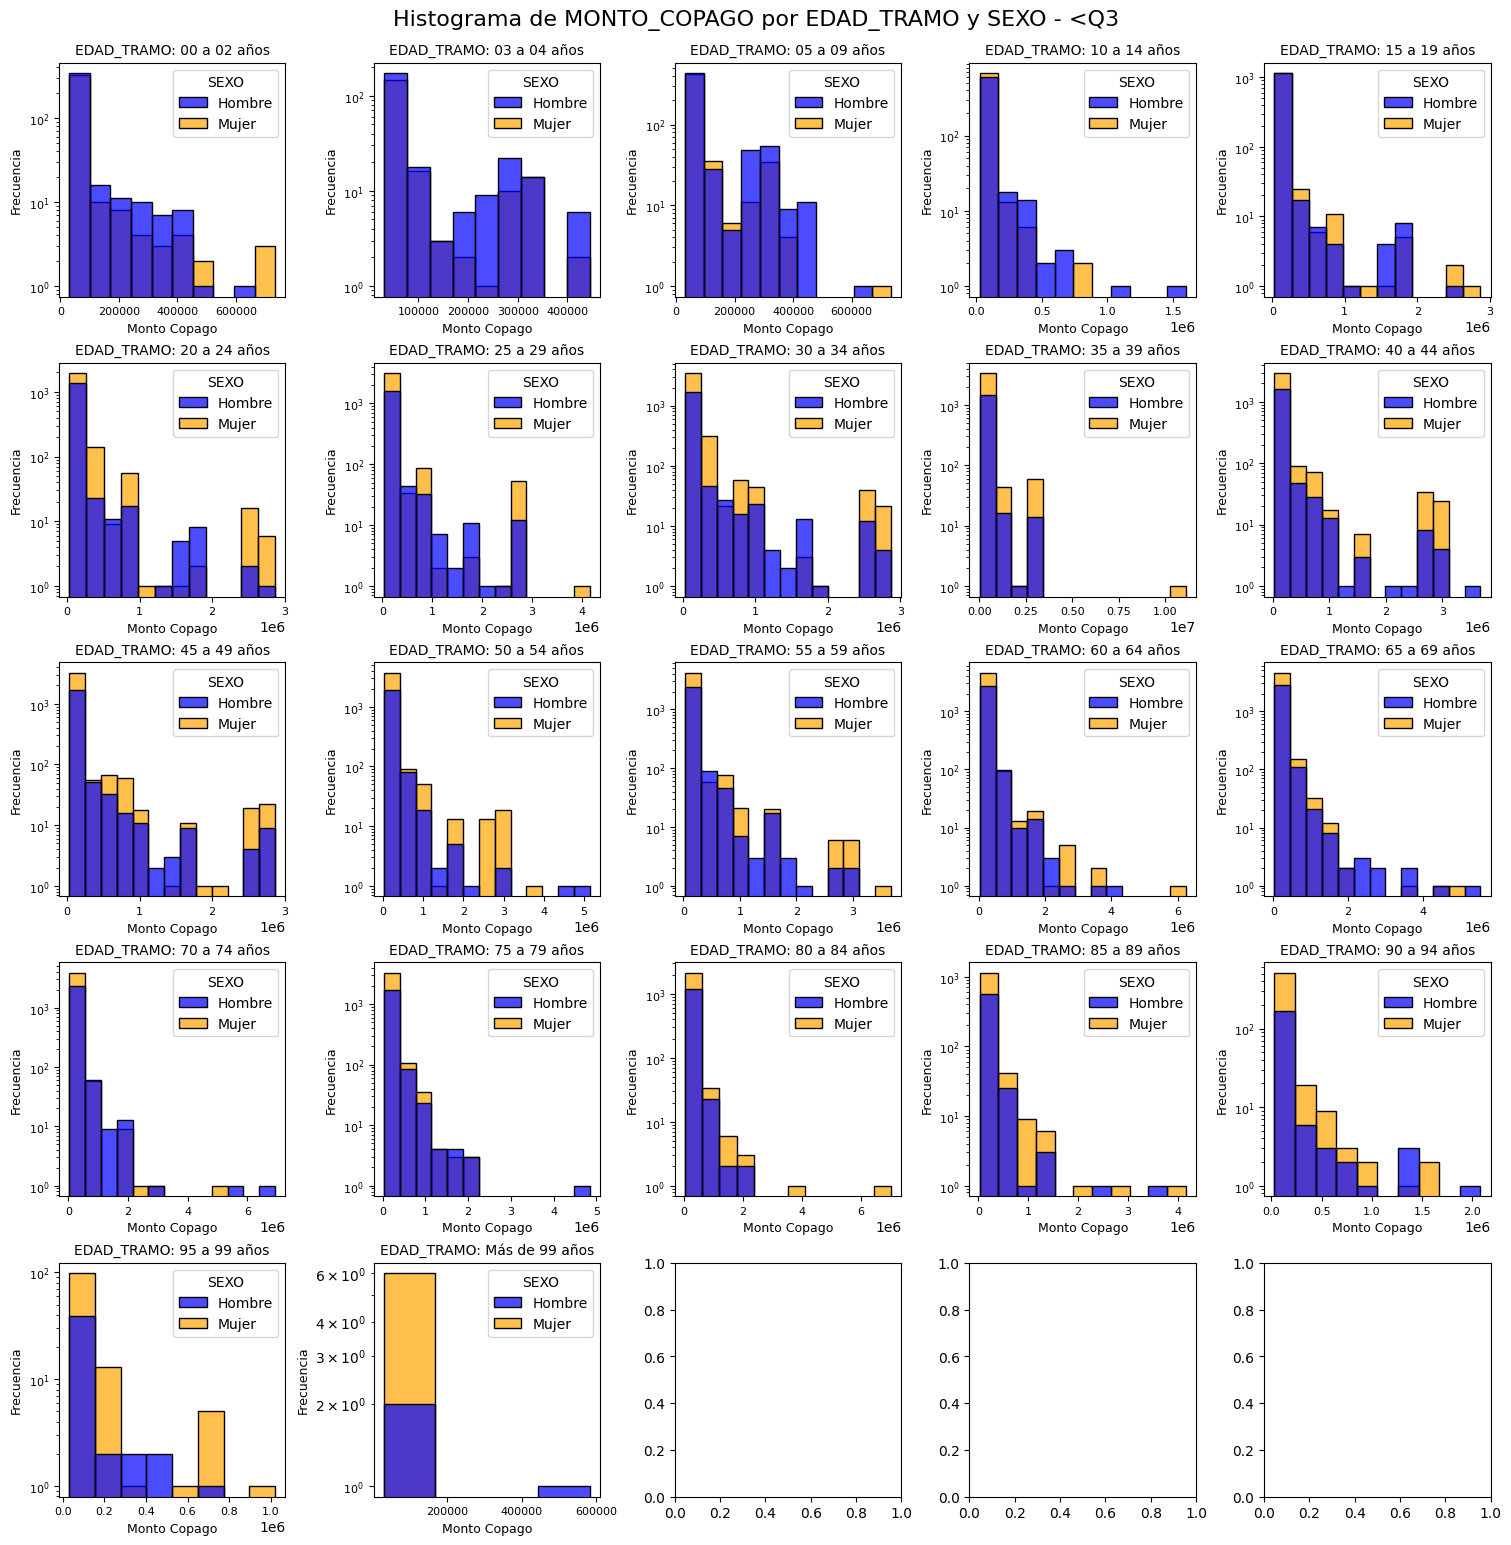

In [26]:
edad_tramos = benef_q4_df["EDAD_TRAMO"].unique()

num_tramos = len(edad_tramos)
cols = 5
rows = int(np.ceil(num_tramos / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), constrained_layout=True)
axes = axes.flatten()

for i, tramo in enumerate(edad_tramos):
    datos_tramo = benef_q4_df[benef_q4_df["EDAD_TRAMO"] == tramo]
    
    if len(datos_tramo) > 0:
        nbins = max(1, int(np.log2(len(datos_tramo)) + 1))
        color_palette = {"Hombre": "blue", "Mujer": "orange"}
        hue_order = ["Hombre", "Mujer"]

        sns.histplot(
            data=datos_tramo,
            x="MONTO_COPAGO",
            hue="SEXO",
            bins=nbins,
            ax=axes[i],
            kde=False,
            hue_order=hue_order,
            palette=color_palette,
            edgecolor="black",
            alpha=0.7
        )

        # Usaremos escala logaritmica dada la poca frecuencia de los valores altos
        axes[i].set_yscale("log")
        
        axes[i].set_title(f"EDAD_TRAMO: {tramo}", fontsize=10)
        axes[i].set_xlabel("Monto Copago", fontsize=9)
        axes[i].set_ylabel("Frecuencia", fontsize=9)
        axes[i].tick_params(axis="x", labelsize=8)
        axes[i].tick_params(axis="y", labelsize=8)
    else:
        axes[i].axis("off")

fig.suptitle("Histograma de MONTO_COPAGO por EDAD_TRAMO y SEXO - <Q3", fontsize=16, y=1.02)
plt.show()

Al analizar el cuartil superior a q3, y utilizando una escala logaritmica vemos que el numero de prestaciones de muy alto valor empiezan a ser mas frecuente a mayor "edad_tramo" de las personas.  
He de notar que las prestaciones de alto valor entre hombre y mujeres parece equiparse en estos tramos de costo.

### Conclusion

**¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?**  
En base a los 3 tipos de analisas hechos: Frecuencia, boxplot e histogramas para cada tramo de edad. Podemos responder que El gasto promedio aumenta por dos motivos. El mayor numero de frecuencia de prestaciones medicas emitidas por persona a medida que aumenta la edad, generando una campana de gauss con valores bajos en edades cercanas a 0 - 10 años y para 80-100+ años.  
El tipo de prestaciones medicas usadas son mas caras en si, el valor promedio de cada prestacion aumenta con la edad, debido a naturalmente la consulta, operaciones, tratamiento de enfermedades mas propensas en edades mas avanzadas, esto es especialmente notables con operaciones de muy alto coste que suelen ser mas frecuente en edades intermedias hasta avanzadas 30-80 años, pero curiosamente en edades sobre 80 años baja.  
El gasto medico, aumenta linealmente con la edad hasta probablemente el fallecimiento de la persona, y baja sobre los 80 años meramente por la menor cantidad de personas que supera dicha edad.